# Imports

In [1]:
## Essential Imports: 
import os
import numpy as np
from pathlib import Path
from pzflow.examples import get_galaxy_data
import tables_io

## RAIL-Specific Imports: 
import rail
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness, LineConfusion, QuantityCut
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.knnpz import Inform_KNearNeighPDF, KNearNeighPDF

from rail.evaluation.evaluator import Evaluator

## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Data Formatting: (from different codes) 
from rail.core.utils import RAILDIR
flow_file = os.path.join(RAILDIR, 'examples/goldenspike/data/pretrained_flow.pkl')
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}
rename_dict = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

import rail
from rail.evaluation.metrics.cdeloss import *
from rail.evaluation.evaluator import Evaluator
from rail.core.data import QPHandle, TableHandle
from rail.core.stage import RailStage
#from rail.evaluation.utils import plot_pit_qq, ks_plot
import qp 
import os
%matplotlib inline
%reload_ext autoreload
%autoreload 2

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Set up Flow Engine 

In [2]:
#path to access the data 
DATA_DIR = Path().resolve() / "data"
DATA_DIR.mkdir(exist_ok=True)

catalog_file = DATA_DIR / "base_catalog.pq"

#array of 100,000 galaxies w/ 7 attributes for each: redshift & ugrizy
catalog = get_galaxy_data().rename(band_dict, axis=1) 

#turns array into a table 
tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

catalog_file = str(catalog_file)
flow_file = str(DATA_DIR / "trained_flow.pkl")

#we set up the stage 
flow_modeler_params = {
    "name": "flow_modeler",
    "input": catalog_file,
    "model": flow_file,
    "seed": 0,
    "phys_cols": {"redshift": [0, 3]},
    "phot_cols": {
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    "calc_colors": {"ref_column_name": "mag_i_lsst"},
}

#we make the stage
flow_modeler = FlowModeler.make_stage(**flow_modeler_params)

#we use the stage to make a model 
flow_modeler.fit_model()

#now we have a model; the next thing to do is to pull datasets from it (and degrade them)

Inserting handle into data store.  input: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/KNN/data/base_catalog.pq, flow_modeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 6.7267
(2) 2.0761
(3) 2.6037
(4) -0.0680
(5) 0.4129
(6) 0.2506
(7) 0.1637
(8) -1.3346
(9) -1.7669
(10) -1.1823
(11) -1.6267
(12) 3402823273761818485311871060541440.0000
(13) 3402823273761818485311871060541440.0000
(14) -1.0711
(15) -0.6228
(16) 3402823273761818485311871060541440.0000
(17) 3402823273761818485311871060541440.0000
(18) -2.8045
(19) -3.3746
(20) 3402823273761818485311871060541440.0000
(21) -2.4881
(22) -3.2147
(23) -3.7188
(24) -3.4398
(25) -3.7955
(26) -3.3772
(27) 3402823273761818485311871060541440.0000
(28) -3.5247
(29) -4.1677
(30) -3.4874
Inserting handle into data store.  model_flow_modeler: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/KNN/data/inprogress_trained_flow.pkl, flow_modeler


# Make Datasets

## invz

In [3]:
flow_modeler.get_handle("model")

In [4]:
flow_creator = FlowCreator.make_stage(
    name='flow_creator', 
    model=flow_modeler.get_handle("model"), 
    n_samples=100000,
    seed=1864,
)

#an un-degraded dataset containing 100,000 galaxies
invz_orig_data_s = flow_creator.sample(100000, 1864)
invz_orig_data_l = flow_creator.sample(100000, 1864)

# the inverse redshift degrader stage
inv_redshift = InvRedshiftIncompleteness.make_stage(
    name='inv_redshift',
    pivot_redshift=1.0,
)

#degraded dataset, using inverse redshift degrader 
invz_deg_data_s = inv_redshift(invz_orig_data_s)
invz_deg_data_l = inv_redshift(invz_orig_data_l)

Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_inv_redshift: inprogress_output_inv_redshift.pq, inv_redshift
Inserting handle into data store.  output_inv_redshift: inprogress_output_inv_redshift.pq, inv_redshift


## linc

In [5]:
flow_modeler.get_handle("model")

In [6]:
flow_creator = FlowCreator.make_stage(
    name='flow_creator', 
    model=flow_modeler.get_handle("model"), 
    n_samples=100000,
    seed=1864,
)

#an un-degraded dataset containing 100,000 galaxies
linc_orig_data_s = flow_creator.sample(100000, 1864)
linc_orig_data_l = flow_creator.sample(100000, 1864)


# the line confusion degrader stage
line_confusion = LineConfusion.make_stage(
    name='line_confusion', 
    true_wavelen=5007., 
    wrong_wavelen=3727.,
    frac_wrong=0.05
)
#degraded dataset, using inverse redshift degrader 
linc_deg_data_s = line_confusion(linc_orig_data_s)
linc_deg_data_l = line_confusion(linc_orig_data_l)

Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_line_confusion: inprogress_output_line_confusion.pq, line_confusion
Inserting handle into data store.  output_line_confusion: inprogress_output_line_confusion.pq, line_confusion


## lsst

In [7]:
flow_modeler.get_handle("model")

In [8]:
flow_creator = FlowCreator.make_stage(
    name='flow_creator', 
    model=flow_modeler.get_handle("model"), 
    n_samples=100000,
    seed=1864,
)

#an un-degraded dataset containing 100,000 galaxies
lsst_orig_data_s = flow_creator.sample(100000, 1864)
lsst_orig_data_l = flow_creator.sample(100000, 1864)

# the lsst error model degrader stage
lsst_error_model = LSSTErrorModel.make_stage(
    name='lsst_error_model_deg',
    bandNames=band_dict, 
    seed=29,
)

#degraded dataset, using inverse redshift degrader 
lsst_deg_data_s = lsst_error_model(lsst_orig_data_s)
lsst_deg_data_l = lsst_error_model(lsst_orig_data_l)

Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_lsst_error_model_deg: inprogress_output_lsst_error_model_deg.pq, lsst_error_model_deg
Inserting handle into data store.  output_lsst_error_model_deg: inprogress_output_lsst_error_model_deg.pq, lsst_error_model_deg


## qcut

In [9]:
flow_modeler.get_handle("model")

In [10]:
flow_creator = FlowCreator.make_stage(
    name='flow_creator', 
    model=flow_modeler.get_handle("model"), 
    n_samples=100000,
    seed=1864,
)

#an un-degraded dataset containing 100,000 galaxies
qcut_orig_data_s = flow_creator.sample(100000, 1864)
qcut_orig_data_l = flow_creator.sample(100000, 1864)

# the quantity cut degrader stage
quantity_cut = QuantityCut.make_stage(
    name='quantity_cut',    
    cuts={'mag_i_lsst': 25.0},
)

#degraded dataset, using inverse redshift degrader 
qcut_deg_data_s = quantity_cut(qcut_orig_data_s)
qcut_deg_data_l = quantity_cut(qcut_orig_data_l)

Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_flow_creator: inprogress_output_flow_creator.pq, flow_creator
Inserting handle into data store.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut
Inserting handle into data store.  output_quantity_cut: inprogress_output_quantity_cut.pq, quantity_cut


# Posteriors

## invz

In [11]:
# invz_flow_post_orig = FlowPosterior.make_stage(name='truth_post_invz_orig', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = invz_orig_data_l)

# invz_orig_pdfs = invz_flow_post_orig.get_posterior(invz_orig_data_l, column='redshift')

In [12]:
# invz_flow_post_deg = FlowPosterior.make_stage(name='truth_post_invz_deg', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = invz_deg_data_l)

# invz_deg_pdfs = invz_flow_post_deg.get_posterior(invz_deg_data_l, column='redshift')

## linc

In [13]:
# linc_flow_post_orig = FlowPosterior.make_stage(name='truth_post_linc_orig', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = linc_orig_data)

# linc_orig_pdfs = linc_flow_post_orig.get_posterior(linc_orig_data, column='redshift')

In [14]:
# linc_flow_post_orig = invz_flow_post_orig

In [15]:
# linc_flow_post_deg = FlowPosterior.make_stage(name='truth_post_linc_deg', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = linc_deg_data_l)

# linc_deg_pdfs = linc_flow_post_deg.get_posterior(linc_deg_data_l, column='redshift')

## lsst

In [16]:
# lsst_flow_post_orig = FlowPosterior.make_stage(name='truth_post_lsst_orig', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = lsst_orig_data)

# lsst_orig_pdfs = lsst_flow_post_orig.get_posterior(lsst_orig_data, column='redshift')

In [17]:
# lsst_flow_post_orig = invz_flow_post_orig 

In [18]:
# lsst_flow_post_deg = FlowPosterior.make_stage(name='truth_post_lsst_deg', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = lsst_deg_data_l,
#                                              )
                                             

# lsst_deg_pdfs = lsst_flow_post_deg.get_posterior(lsst_deg_data_l, column='redshift')

## qcut

In [19]:
# qcut_flow_post_orig = FlowPosterior.make_stage(name='truth_post_qcut_orig', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = qcut_orig_data)

# qcut_orig_pdfs = qcut_flow_post_orig.get_posterior(qcut_orig_data, column='redshift')

In [20]:
# qcut_flow_post_orig = invz_flow_post_orig

In [21]:
# qcut_flow_post_deg = FlowPosterior.make_stage(name='truth_post_qcut_deg', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = qcut_deg_data_l)

# qcut_deg_pdfs = qcut_flow_post_deg.get_posterior(qcut_deg_data_l, column='redshift')

# Tables 

In [22]:
def makeTable(dataset):
    col_remapper = ColumnMapper.make_stage(
    name='col_remapper', 
    columns=rename_dict)

    table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict')
    pq = col_remapper(dataset)
    pq_data = table_conv(dataset)
    table = tables_io.convertObj(pq_data.data, tables_io.types.PD_DATAFRAME)
    return table 

## invz

In [23]:
invz_orig_table = makeTable(invz_orig_data_l)
invz_deg_table = makeTable(invz_deg_data_l)

invz_orig_table
invz_deg_table

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv
Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.980219,28.717247,28.043226,26.935120,25.974754,25.262276,24.988197
1,0.336962,26.750130,26.237349,25.686253,25.562122,25.426531,25.483788
2,1.058445,26.427927,26.156200,25.467705,24.669821,23.986652,23.638468
3,1.710162,28.261900,27.878426,27.499338,27.101761,26.561159,26.140568
4,1.049813,26.405678,25.780752,24.689110,23.941168,23.117826,22.752045
...,...,...,...,...,...,...,...
83101,0.822037,24.565582,24.334368,23.870855,23.159513,22.798336,22.726400
83102,1.456850,25.806974,25.552200,25.456583,25.204376,25.052702,24.601746
83103,2.011781,29.545815,28.386770,27.457928,27.118486,26.261799,25.521345
83104,0.626923,24.771667,23.945906,22.953171,22.189484,21.942114,21.764332


## linc

In [24]:
linc_orig_table = makeTable(linc_orig_data_l)
linc_deg_table = makeTable(linc_deg_data_l) 

linc_orig_table
linc_deg_table

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv
Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,0.980219,28.717247,28.043226,26.935120,25.974754,25.262276,24.988197
1,0.336962,26.750130,26.237349,25.686253,25.562122,25.426531,25.483788
2,1.058445,26.427927,26.156200,25.467705,24.669821,23.986652,23.638468
3,2.084974,26.465586,26.245998,25.998940,25.914877,25.679785,25.399582
4,1.710162,28.261900,27.878426,27.499338,27.101761,26.561159,26.140568
...,...,...,...,...,...,...,...
99995,0.822037,24.565582,24.334368,23.870855,23.159513,22.798336,22.726400
99996,1.456850,25.806974,25.552200,25.456583,25.204376,25.052702,24.601746
99997,2.011781,29.545815,28.386770,27.457928,27.118486,26.261799,25.521345
99998,0.626923,24.771667,23.945906,22.953171,22.189484,21.942114,21.764332


## lsst

In [25]:
lsst_orig_table = makeTable(lsst_orig_data_l)
lsst_deg_table = makeTable(lsst_deg_data_l) 

lsst_orig_table
lsst_deg_table

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv
Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_u_lsst_err,mag_g_lsst,mag_g_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_z_lsst,mag_z_lsst_err,mag_y_lsst,mag_y_lsst_err
0,0.980219,NaN,NaN,28.021859,0.357849,26.960771,0.146745,25.990920,0.092863,25.256694,0.085447,25.025634,0.156843
1,0.336962,26.632646,0.322194,26.241382,0.079633,25.658795,0.046725,25.606025,0.066112,25.464655,0.102566,25.729803,0.282346
2,1.058445,27.133775,0.474209,26.341855,0.086999,25.465294,0.039356,24.694390,0.029492,24.008122,0.028321,23.666365,0.047585
3,2.084974,26.338883,0.254164,26.199879,0.076771,25.955195,0.060789,25.834317,0.080902,25.345952,0.092427,25.331619,0.203281
4,1.710162,28.029426,0.879854,29.368879,0.927284,28.053767,0.361841,26.630581,0.161753,25.956564,0.157056,25.948542,0.336418
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.822037,24.637175,0.058895,24.323373,0.015093,23.880211,0.010591,23.164637,0.008863,22.809605,0.010698,22.705803,0.020521
99996,1.456850,25.579928,0.134149,25.624427,0.046129,25.407377,0.037389,25.195660,0.045932,25.115719,0.075454,24.355076,0.087559
99997,2.011781,29.324672,1.772187,28.633992,0.567024,27.417710,0.216149,27.420533,0.311463,26.190954,0.191659,25.322479,0.201728
99998,0.626923,24.793575,0.067578,23.921916,0.011133,22.952928,0.006461,22.203198,0.005902,21.949443,0.006663,21.774962,0.009953


## qcut

In [26]:
qcut_orig_table = makeTable(qcut_orig_data_l)
qcut_deg_table = makeTable(qcut_deg_data_l) 

qcut_orig_table
qcut_deg_table

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv
Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


,redshift,mag_u_lsst,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst
0,1.058445,26.427927,26.156200,25.467705,24.669821,23.986652,23.638468
1,1.049813,26.405678,25.780752,24.689110,23.941168,23.117826,22.752045
2,0.563949,24.277168,23.783470,22.722559,22.026419,21.758356,21.550240
3,0.777649,25.148439,24.820963,24.439817,23.907490,23.731321,23.639647
4,0.577233,25.004028,23.858694,22.539780,21.903397,21.640217,21.384560
...,...,...,...,...,...,...,...
35712,1.499904,25.568008,25.145218,24.896315,24.497118,24.250044,23.758213
35713,0.925658,27.737541,27.107098,25.703175,24.671230,23.862034,23.541393
35714,1.233906,26.664337,25.879164,25.029446,24.445734,23.778475,23.300323
35715,0.822037,24.565582,24.334368,23.870855,23.159513,22.798336,22.726400


# Inform & Estimate

## invz

### orig 

In [27]:
Inform_KNearNeighPDF_invz_orig = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_invz_orig', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_invz_orig.inform(invz_orig_data_s)

split into 75000 training and 25000 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.024444444444444446 and numneigh=7



Inserting handle into data store.  model_Inform_KNearNeighPDF_invz_orig: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_invz_orig


In [28]:
## use estimator (informed on orig) on orig 

estimate_knearneigh_invz_orig_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_invz_o_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_invz_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_invz_orig_orig.estimate(invz_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_invz_o_o: inprogress_output_est_knearneigh_100,000_invz_o_o.hdf5, est_knearneigh_100,000_invz_o_o


In [29]:
## use estimator (informed on orig) on deg 

estimate_knearneigh_invz_orig_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_invz_o_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_invz_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_invz_orig_deg.estimate(invz_deg_data_l)

Process 0 running estimator on chunk 0 - 83106
Process 0 estimating PZ PDF for rows 0 - 83,106


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_invz_o_d: inprogress_output_est_knearneigh_100,000_invz_o_d.hdf5, est_knearneigh_100,000_invz_o_d


### deg 

In [30]:
Inform_KNearNeighPDF_invz_deg = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_invz_deg', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_invz_deg.inform(invz_deg_data_s)

split into 62330 training and 20776 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.024444444444444446 and numneigh=7



Inserting handle into data store.  model_Inform_KNearNeighPDF_invz_deg: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_invz_deg


NOTE/WARNING: Expected output file KNearNeighPDF.pkl was not generated.


In [31]:
## use estimator (informed on deg) on orig 

estimate_knearneigh_invz_deg_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_invz_d_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_invz_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_invz_deg_orig.estimate(invz_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_invz_d_o: inprogress_output_est_knearneigh_100,000_invz_d_o.hdf5, est_knearneigh_100,000_invz_d_o


In [32]:
## use estimator (informed on deg) on deg 

estimate_knearneigh_invz_deg_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_invz_d_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_invz_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_invz_deg_deg.estimate(invz_deg_data_l)

Process 0 running estimator on chunk 0 - 83106
Process 0 estimating PZ PDF for rows 0 - 83,106


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_invz_d_d: inprogress_output_est_knearneigh_100,000_invz_d_d.hdf5, est_knearneigh_100,000_invz_d_d


## linc

### orig

In [33]:
Inform_KNearNeighPDF_linc_orig = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_linc_orig', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_linc_orig.inform(linc_orig_data_s)

split into 75000 training and 25000 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.024444444444444446 and numneigh=7



Inserting handle into data store.  model_Inform_KNearNeighPDF_linc_orig: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_linc_orig


NOTE/WARNING: Expected output file KNearNeighPDF.pkl was not generated.


In [34]:
## use estimator (informed on orig) on orig 

estimate_knearneigh_linc_orig_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_linc_o_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_linc_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_linc_orig_orig.estimate(linc_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_linc_o_o: inprogress_output_est_knearneigh_100,000_linc_o_o.hdf5, est_knearneigh_100,000_linc_o_o


In [35]:
## use estimator (informed on orig) on deg 

estimate_knearneigh_linc_orig_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_linc_o_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_linc_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_linc_orig_deg.estimate(linc_deg_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_linc_o_d: inprogress_output_est_knearneigh_100,000_linc_o_d.hdf5, est_knearneigh_100,000_linc_o_d


### deg

In [36]:
Inform_KNearNeighPDF_linc_deg = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_linc_deg', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_linc_deg.inform(linc_deg_data_s)

split into 75000 training and 25000 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.024444444444444446 and numneigh=7



Inserting handle into data store.  model_Inform_KNearNeighPDF_linc_deg: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_linc_deg


NOTE/WARNING: Expected output file KNearNeighPDF.pkl was not generated.


In [37]:
## use estimator (informed on deg) on orig 

estimate_knearneigh_linc_deg_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_linc_d_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_linc_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_linc_deg_orig.estimate(linc_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_linc_d_o: inprogress_output_est_knearneigh_100,000_linc_d_o.hdf5, est_knearneigh_100,000_linc_d_o


In [38]:
## use estimator (informed on deg) on deg 

estimate_knearneigh_linc_deg_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_linc_d_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_linc_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_linc_deg_deg.estimate(linc_deg_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_linc_d_d: inprogress_output_est_knearneigh_100,000_linc_d_d.hdf5, est_knearneigh_100,000_linc_d_d


## lsst

### orig

In [39]:
Inform_KNearNeighPDF_lsst_orig = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_lsst_orig', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_lsst_orig.inform(lsst_orig_data_s)

split into 75000 training and 25000 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.024444444444444446 and numneigh=7



Inserting handle into data store.  model_Inform_KNearNeighPDF_lsst_orig: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_lsst_orig


NOTE/WARNING: Expected output file KNearNeighPDF.pkl was not generated.


In [40]:
estimate_knearneigh_lsst_orig_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_lsst_o_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_lsst_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_lsst_orig_orig.estimate(lsst_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_lsst_o_o: inprogress_output_est_knearneigh_100,000_lsst_o_o.hdf5, est_knearneigh_100,000_lsst_o_o


In [41]:
estimate_knearneigh_lsst_orig_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_lsst_o_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_lsst_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_lsst_orig_deg.estimate(lsst_deg_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000
Inserting handle into data store.  output_est_knearneigh_100,000_lsst_o_d: inprogress_output_est_knearneigh_100,000_lsst_o_d.hdf5, est_knearneigh_100,000_lsst_o_d


### deg

In [42]:
Inform_KNearNeighPDF_lsst_deg = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_lsst_deg', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_lsst_deg.inform(lsst_deg_data_s)

split into 75000 training and 25000 validation samples


ValueError: Input contains NaN.

In [ ]:
estimate_knearneigh_lsst_deg_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_lsst_d_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_lsst_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_lsst_deg_orig.estimate(lsst_orig_data_l)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_est_fzboost_lsst_d_o: inprogress_output_est_fzboost_lsst_d_o.hdf5, est_fzboost_lsst_d_o


In [ ]:
estimate_knearneigh_lsst_deg_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_lsst_d_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_lsst_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_lsst_deg_deg.estimate(lsst_deg_data_l)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_est_fzboost_lsst_d_d: inprogress_output_est_fzboost_lsst_d_d.hdf5, est_fzboost_lsst_d_d


## qcut

### orig

In [43]:
Inform_KNearNeighPDF_qcut_orig = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_qcut_orig', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_qcut_orig.inform(qcut_orig_data_s)

split into 75000 training and 25000 validation samples
finding best fit sigma and NNeigh...





best fit values are sigma=0.024444444444444446 and numneigh=7



Inserting handle into data store.  model_Inform_KNearNeighPDF_qcut_orig: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_qcut_orig


NOTE/WARNING: Expected output file KNearNeighPDF.pkl was not generated.


In [44]:
estimate_knearneigh_qcut_orig_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_qcut_o_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_qcut_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_qcut_orig_orig.estimate(qcut_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_qcut_o_o: inprogress_output_est_knearneigh_100,000_qcut_o_o.hdf5, est_knearneigh_100,000_qcut_o_o


In [45]:
estimate_knearneigh_qcut_orig_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_qcut_o_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_qcut_orig.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_qcut_orig_deg.estimate(qcut_deg_data_l)

Process 0 running estimator on chunk 0 - 35717
Process 0 estimating PZ PDF for rows 0 - 35,717


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_qcut_o_d: inprogress_output_est_knearneigh_100,000_qcut_o_d.hdf5, est_knearneigh_100,000_qcut_o_d


### deg

In [46]:
Inform_KNearNeighPDF_qcut_deg = Inform_KNearNeighPDF.make_stage(
    name='Inform_KNearNeighPDF_qcut_deg', 
    model='KNearNeighPDF.pkl', 
    hdf5_groupname='',
)

Inform_KNearNeighPDF_qcut_deg.inform(qcut_deg_data_s)

split into 26788 training and 8929 validation samples
finding best fit sigma and NNeigh...



best fit values are sigma=0.03166666666666667 and numneigh=5



Inserting handle into data store.  model_Inform_KNearNeighPDF_qcut_deg: inprogress_KNearNeighPDF.pkl, Inform_KNearNeighPDF_qcut_deg


NOTE/WARNING: Expected output file KNearNeighPDF.pkl was not generated.


In [47]:
estimate_knearneigh_qcut_deg_orig = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_qcut_d_o', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_qcut_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_qcut_deg_orig.estimate(qcut_orig_data_l)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_qcut_d_o: inprogress_output_est_knearneigh_100,000_qcut_d_o.hdf5, est_knearneigh_100,000_qcut_d_o


In [48]:
estimate_knearneigh_qcut_deg_deg = KNearNeighPDF.make_stage(
    name='est_knearneigh_100,000_qcut_d_d', 
    nondetect_val=np.nan,
    model=Inform_KNearNeighPDF_qcut_deg.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='knearneigh_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

estimate_knearneigh_qcut_deg_deg.estimate(qcut_deg_data_l)

Process 0 running estimator on chunk 0 - 35717
Process 0 estimating PZ PDF for rows 0 - 35,717


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:35: RuntimeWarning: divide by zero encountered in divide
  weights = 1. / dists
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/knnpz.py:36: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum(axis=1, keepdims=True)


Inserting handle into data store.  output_est_knearneigh_100,000_qcut_d_d: inprogress_output_est_knearneigh_100,000_qcut_d_d.hdf5, est_knearneigh_100,000_qcut_d_d


# Evaluation Setup

In [49]:
# def getEnsTuple(file):
#     yvals = file.objdata()['yvals']
#     xvals = file.metadata()['xvals'][0]
#     ens = qp.Ensemble(qp.interp, data=dict(xvals=xvals, yvals=yvals))
#     two = [xvals, yvals]
#     return [ens, two]


## invz

In [50]:
# invz_orig_ens = [
# getEnsTuple(getFile('output_truth_post_invz_orig.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_o_o.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_d_o.hdf5'))[0]
# ]
# invz_deg_ens = [
# getEnsTuple(getFile('output_truth_post_invz_deg.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_o_d.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_d_d.hdf5'))[0]
# ]

# invz_orig_tuples = [
# getEnsTuple(getFile('output_truth_post_invz_orig.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_o_o.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_d_o.hdf5'))[1]
# ]
# invz_deg_tuples = [
# getEnsTuple(getFile('output_truth_post_invz_deg.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_o_d.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_invz_d_d.hdf5'))[1]
# ]

## linc

In [51]:
# linc_orig_ens = [
# getEnsTuple(getFile('output_truth_post_linc_orig.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_o_o.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_d_o.hdf5'))[0]
# ]
# linc_deg_ens = [
# getEnsTuple(getFile('output_truth_post_linc_deg.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_o_d.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_d_d.hdf5'))[0]
# ]

# linc_orig_tuples = [
# getEnsTuple(getFile('output_truth_post_linc_orig.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_o_o.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_d_o.hdf5'))[1]
# ]
# linc_deg_tuples = [
# getEnsTuple(getFile('output_truth_post_linc_deg.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_o_d.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_linc_d_d.hdf5'))[1]
# ]

## lsst

In [52]:
# lsst_orig_ens = [
# getEnsTuple(getFile('output_truth_post_lsst_orig.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_o_o.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_d_o.hdf5'))[0]
# ]
# lsst_deg_ens = [
# getEnsTuple(getFile('output_truth_post_lsst_deg.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_o_d.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_d_d.hdf5'))[0]
# ]

# lsst_orig_tuples = [
# getEnsTuple(getFile('output_truth_post_lsst_orig.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_o_o.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_d_o.hdf5'))[1]
# ]
# lsst_deg_tuples = [
# getEnsTuple(getFile('output_truth_post_lsst_deg.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_o_d.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_lsst_d_d.hdf5'))[1]
# ]

## qcut

In [53]:
# qcut_orig_ens = [
# getEnsTuple(getFile('output_truth_post_qcut_orig.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_o_o.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_d_o.hdf5'))[0]
# ]
# qcut_deg_ens = [
# getEnsTuple(getFile('output_truth_post_qcut_deg.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_o_d.hdf5'))[0], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_d_d.hdf5'))[0]
# ]

# qcut_orig_tuples = [
# getEnsTuple(getFile('output_truth_post_qcut_orig.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_o_o.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_d_o.hdf5'))[1]
# ]
# qcut_deg_tuples = [
# getEnsTuple(getFile('output_truth_post_qcut_deg.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_o_d.hdf5'))[1], 
# getEnsTuple(getFile('output_est_knearneigh_100,000_qcut_d_d.hdf5'))[1]
# ]

# Plots 

In [54]:
# import matplotlib.pyplot as plt


# ## for whatever reason this doesnt quite work 
# def makePlots1(tuples, num):
#     fig, axes = plt.subplots(nrows = num, ncols = num, figsize = (3*num, 2*num)) 

#     ct = 0
#     for i in range(0, len(tuples)):
#         for j in range(0, num):
#             for k in range(0, num):
#                 axes[j][k].plot(tuples[i][0], tuples[i][1][ct])
#                 ct += 1


# ## this does tho 
# def makePlots2(two, num):
#     fig, axes = plt.subplots(nrows = num, ncols = num, figsize = (3*num, 2*num)) 

#     ct = 0
#     for i in range(0, num):
#         for j in range(0, num):
#             axes[i][j].plot(two[0], two[1][ct])
#             ct += 1

## invz

In [55]:
# #makePlots1(invz_orig_tuples, 6)

# makePlots2(invz_orig_tuples[0], 6)
# makePlots2(invz_orig_tuples[1], 6)
# makePlots2(invz_orig_tuples[2], 6)

In [56]:
# makePlots2(invz_deg_tuples[0], 6)
# makePlots2(invz_deg_tuples[1], 6)
# makePlots2(invz_deg_uples[2], 6)

## linc

In [57]:
# linc_orig_tuples = [linc_orig_truth_tuple, linc_o_o_tuple, linc_d_o_tuple]

# #makePlots1(invz_orig_tuples, 6)

# makePlots2(linc_orig_tuples[0], 6)
# makePlots2(linc_orig_tuples[1], 6)
# makePlots2(linc_orig_uples[2], 6)

In [58]:
# linc_deg_tuples = [linc_deg_truth_tuple, linc_o_d_tuple, linc_d_d_tuple]

# #makePlots1(invz_deg_tuples, 6)

# makePlots2(linc_deg_tuples[0], 6)
# makePlots2(linc_deg_tuples[1], 6)
# makePlots2(linc_deg_uples[2], 6)

# KLD

In [59]:
# import h5py 
# import qp

# lims = np.array([0, 2.5])
# grid = np.linspace(0, 2.5, 100)

# def getKLDs(ens1, ens2, lims, grid):
#     klds = qp.metrics.calculate_kld(invz_orig_truth_ens, invz_o_o_ens, limits=lims, dx = grid[1] - grid[0])
#     return klds

## invz

In [60]:
# invz_o_o_klds = getKLDs(invz_orig_truth_ens, invz_o_o_ens, lims, grid)
# invz_d_o_klds = getKLDs(invz_orig_truth_ens, invz_d_o_ens, lims, grid)
# invz_o_d_klds = getKLDs(invz_deg_truth_ens, invz_o_d_ens, lims, grid)
# invz_d_d_klds = getKLDs(invz_deg_truth_ens, invz_d_d_ens, lims, grid)

## linc

In [61]:
# linc_o_o_klds = getKLDs(linc_orig_truth_ens, linc_o_o_ens, lims, grid)
# linc_d_o_klds = getKLDs(linc_orig_truth_ens, linc_d_o_ens, lims, grid)
# linc_o_d_klds = getKLDs(linc_deg_truth_ens, linc_o_d_ens, lims, grid)
# linc_d_d_klds = getKLDs(linc_deg_truth_ens, linc_d_d_ens, lims, grid)

# PIT

In [62]:
from qp.metrics.pit import PIT
import matplotlib.pyplot as plt
import numpy as np

def getFile(filename):
    file = DS.read_file('pdfs_data', QPHandle, filename)
    return file()

def getPIT(file, table):
    pits = PIT(file, np.asarray(table)[:,0])
    pit = pits._pit_samps
    return pit

def plotPITs(pits):
    ls = []
    degraders = ['orig, orig', 'orig, deg', 'deg, orig', 'deg, deg']
    ct = 0
    for i in pits:
        hist = plt.hist(i, bins = 100, alpha = 0.5, label = degraders[ct])
        plt.ylim(0, 2000)
        plt.ylabel("Bin Count")
        plt.xlabel('$\int_{-\infty}^{z_{true}} \! \hat{p}(z|photometry) \, dz $', fontsize = 'large')
        plt.title('FlexZBoost PIT Histogram with Quantity Cuts Degradation', fontsize = 'large', fontweight = 'bold')
        plt.legend()
        ls.append(hist)
        ct += 1
    return ls

def PITOutlierRates(ls):
    names = ['o_o', 'o_d', 'd_o', 'd_d']
    ct = 0
    rates = []
    for i in ls:
        rate = (i[0][0] + i[0][-1]) / np.sum(i[0]) * 100
        print(names[ct], 'outlier rate is:', rate, '%')
        ct += 1
        rates.append(str(rate) + '%')
    return rates


## invz

In [63]:
invz_pits = [
getPIT(getFile('output_est_knearneigh_100,000_invz_o_o.hdf5'), invz_orig_table), 
getPIT(getFile('output_est_knearneigh_100,000_invz_o_d.hdf5'), invz_deg_table), 
getPIT(getFile('output_est_knearneigh_100,000_invz_d_o.hdf5'), invz_orig_table), 
getPIT(getFile('output_est_knearneigh_100,000_invz_d_d.hdf5'), invz_deg_table)
]

ValueError: zero-size array to reduction operation minimum which has no identity

o_o outlier rate is: 1.6400000000000001 %
o_d outlier rate is: 1.6125179168657429 %
d_o outlier rate is: 2.26 %
d_d outlier rate is: 1.2183468705207836 %


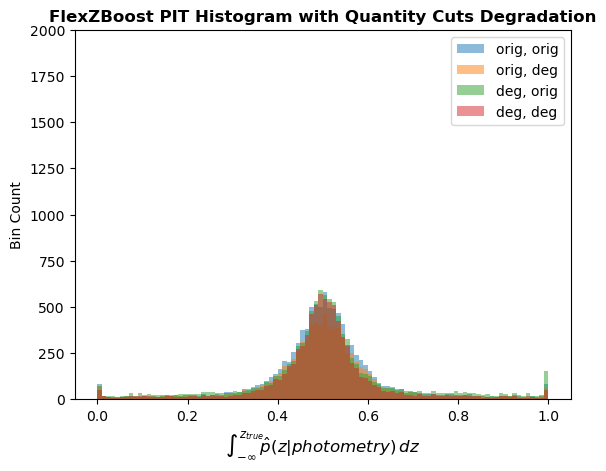

In [ ]:
invz_pit_outs = PITOutlierRates(plotPITs(invz_pits))


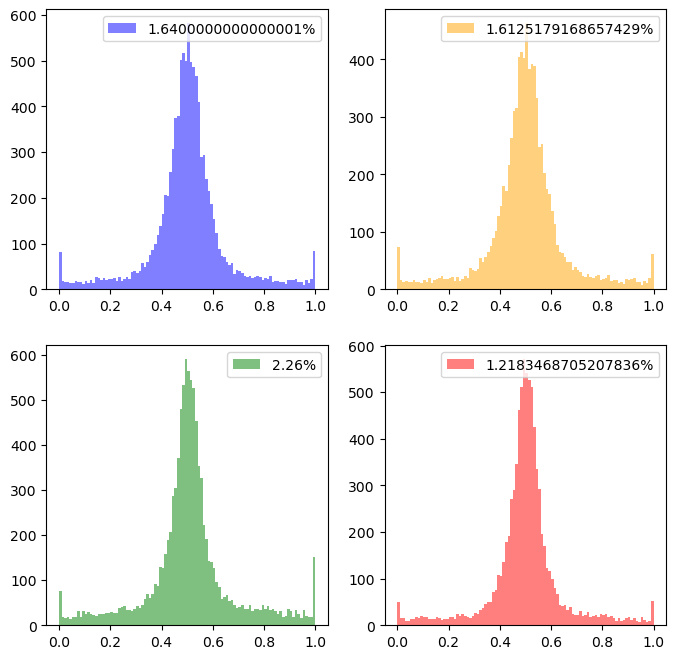

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
axes[0][0].hist(invz_pits[0], bins = 100, alpha = 0.5, color = 'blue', label = invz_pit_outs[0])
axes[0][1].hist(invz_pits[1], bins = 100, alpha = 0.5, color = 'orange', label = invz_pit_outs[1])
axes[1][0].hist(invz_pits[2], bins = 100, alpha = 0.5, color = 'green', label = invz_pit_outs[2])
axes[1][1].hist(invz_pits[3], bins = 100, alpha = 0.5, color = 'red', label = invz_pit_outs[3])

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

## linc

In [ ]:
linc_pits = [
getPIT(getFile('output_est_knearneigh_100,000_linc_o_o.hdf5'), linc_orig_table), 
getPIT(getFile('output_est_knearneigh_100,000_linc_d_o.hdf5'), linc_orig_table), 
getPIT(getFile('output_est_knearneigh_100,000_linc_o_d.hdf5'), linc_deg_table), 
getPIT(getFile('output_est_knearneigh_100,000_linc_d_d.hdf5'), linc_deg_table)
]

o_o outlier rate is: 1.6400000000000001 %
o_d outlier rate is: 4.9799999999999995 %
d_o outlier rate is: 6.550000000000001 %
d_d outlier rate is: 2.9899999999999998 %


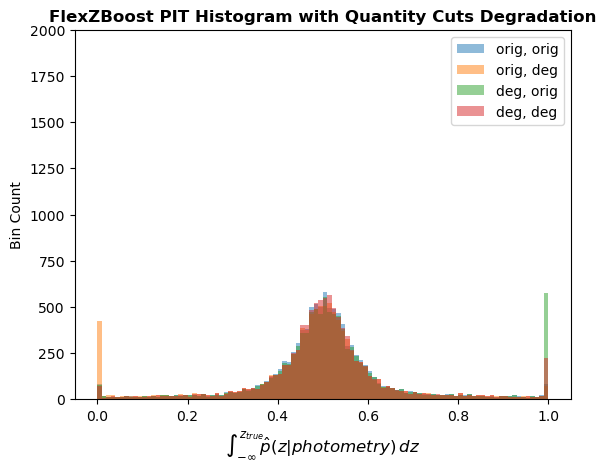

In [ ]:
linc_pit_outs = PITOutlierRates(plotPITs(linc_pits))

(array([ 75.,  10.,  14.,  17.,  11.,  14.,  16.,  14.,  16.,  15.,  11.,
         16.,  21.,  22.,  20.,  21.,  16.,  16.,  25.,  25.,  15.,  31.,
         30.,  27.,  26.,  18.,  33.,  20.,  31.,  43.,  41.,  47.,  62.,
         55.,  60.,  55.,  79.,  92., 129., 131., 140., 188., 185., 253.,
        267., 403., 401., 486., 521., 536., 546., 563., 495., 448., 384.,
        341., 268., 209., 204., 179., 127., 109., 111.,  64.,  71.,  60.,
         50.,  46.,  48.,  31.,  40.,  29.,  32.,  31.,  25.,  27.,  22.,
         25.,  23.,  19.,  32.,  18.,  22.,  17.,  24.,  26.,  19.,  22.,
         15.,  20.,  19.,  14.,  15.,  12.,  13.,  16.,  13.,  12.,  20.,
        224.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

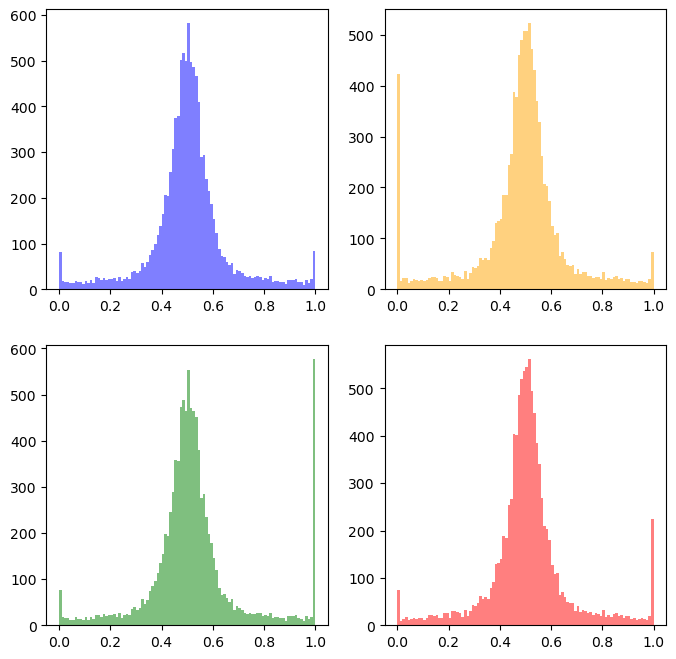

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
axes[0][0].hist(linc_pits[0], bins = 100, alpha = 0.5, color = 'blue', label = linc_pit_outs[0])
axes[0][1].hist(linc_pits[1], bins = 100, alpha = 0.5, color = 'orange', label = linc_pit_outs[1])
axes[1][0].hist(linc_pits[2], bins = 100, alpha = 0.5, color = 'green', label = linc_pit_outs[2])
axes[1][1].hist(linc_pits[3], bins = 100, alpha = 0.5, color = 'red', label = linc_pit_outs[3])


## lsst

In [ ]:
# lsst_pits = [
# getPIT(getFile('output_est_knearneigh_100,000_lsst_o_o.hdf5'), lsst_orig_table), 
# getPIT(getFile('output_est_knearneigh_100,000_lsst_o_d.hdf5'), lsst_deg_table), 
# getPIT(getFile('output_est_knearneigh_100,000_lsst_d_o.hdf5'), lsst_orig_table), 
# getPIT(getFile('output_est_knearneigh_100,000_lsst_d_d.hdf5'), lsst_deg_table)
# ]

o_o outlier rate is: 1.6400000000000001 %
o_d outlier rate is: 40.08 %
d_o outlier rate is: 2.8400000000000003 %
d_d outlier rate is: 2.3 %


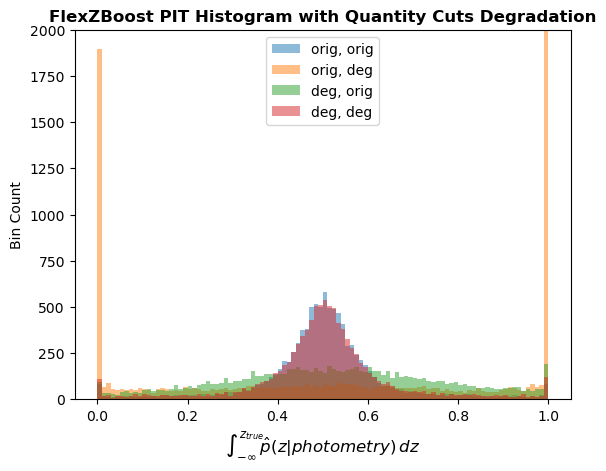

In [ ]:
# lsst_pit_outs = PITOutlierRates(plotPITs(lsst_pits))

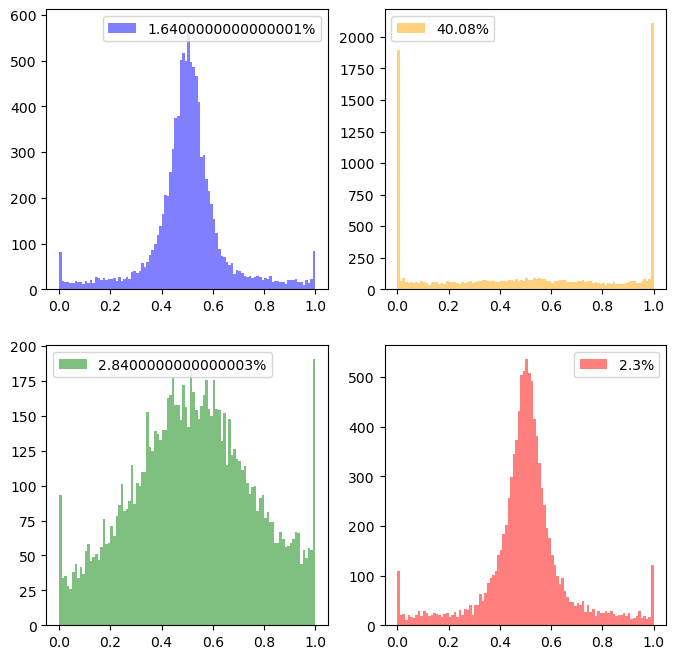

In [ ]:
# fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
# axes[0][0].hist(lsst_pits[0], bins = 100, alpha = 0.5, color = 'blue', label = lsst_pit_outs[0])
# axes[0][1].hist(lsst_pits[1], bins = 100, alpha = 0.5, color = 'orange', label = lsst_pit_outs[1])
# axes[1][0].hist(lsst_pits[2], bins = 100, alpha = 0.5, color = 'green', label = lsst_pit_outs[2])
# axes[1][1].hist(lsst_pits[3], bins = 100, alpha = 0.5, color = 'red', label = lsst_pit_outs[3])

# handles1, labels1 = axes[0][0].get_legend_handles_labels()
# axes[0][0].legend(handles1, labels1)
# handles2, labels2 = axes[0][1].get_legend_handles_labels()
# axes[0][1].legend(handles2, labels2)
# handles3, labels3 = axes[1][0].get_legend_handles_labels()
# axes[1][0].legend(handles3, labels3)
# handles4, labels4 = axes[1][1].get_legend_handles_labels()
# axes[1][1].legend(handles4, labels4)


## qcut

In [ ]:
qcut_pits = [
getPIT(getFile('output_est_knearneigh_100,000_qcut_o_o.hdf5'), qcut_orig_table), 
getPIT(getFile('output_est_knearneigh_100,000_qcut_o_d.hdf5'), qcut_deg_table), 
getPIT(getFile('output_est_knearneigh_100,000_qcut_d_o.hdf5'), qcut_orig_table), 
getPIT(getFile('output_est_knearneigh_100,000_qcut_d_d.hdf5'), qcut_deg_table)
]

o_o outlier rate is: 1.6400000000000001 %
o_d outlier rate is: 1.8851756640959727 %
d_o outlier rate is: 15.659999999999998 %
d_d outlier rate is: 1.2853470437017995 %


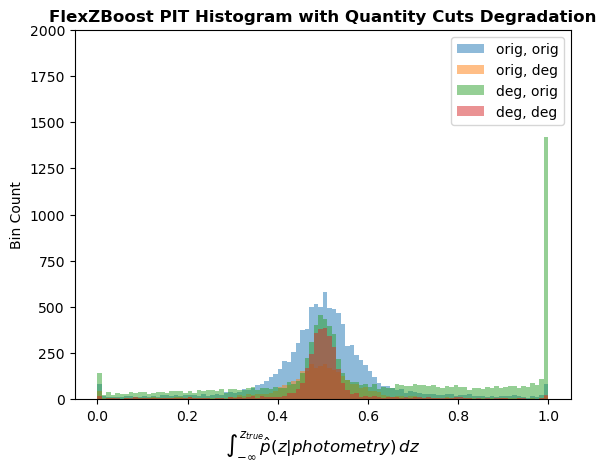

In [ ]:
qcut_pit_outs = PITOutlierRates(plotPITs(qcut_pits))

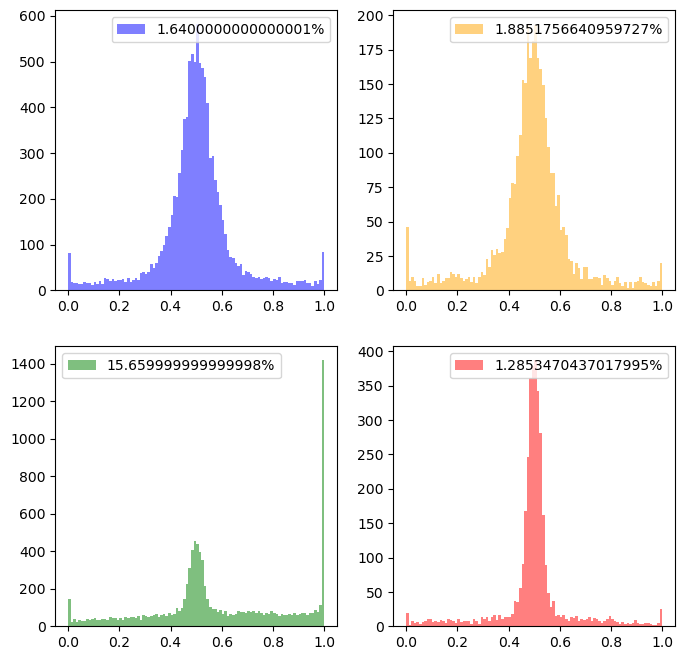

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
axes[0][0].hist(qcut_pits[0], bins = 100, alpha = 0.5, color = 'blue', label = qcut_pit_outs[0])
axes[0][1].hist(qcut_pits[1], bins = 100, alpha = 0.5, color = 'orange', label = qcut_pit_outs[1])
axes[1][0].hist(qcut_pits[2], bins = 100, alpha = 0.5, color = 'green', label = qcut_pit_outs[2])
axes[1][1].hist(qcut_pits[3], bins = 100, alpha = 0.5, color = 'red', label = qcut_pit_outs[3])

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

# Outlier Rejection 

In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import norm
import h5py

def getXValsYVals(filename):
    file = h5py.File(filename, 'r')
    data = file['data']
    meta = file['meta']
    yvals = np.asarray(data['yvals'])
    xvals = np.asarray(meta['xvals'])[0]
    return [xvals, yvals]

def getMeans(tuple):
    means = []
    for i in range(len(tuple[1])):
        mean = np.sum(tuple[0] * tuple[1][i]) / np.sum(tuple[1][i])
        means.append(mean)
    return np.asarray(means)

def outlierRejection(ls, lim):
    mean = np.mean(ls)
    stdev = stats.tstd(ls)
    ct = 0
    for i in ls:
        if np.abs(mean - i) > 3*stdev:
            ls.remove(i) 
            ct += 1
    if ct <= lim:
        return ls
    else:
        return outlierRejection(ls, lim)

def runRejection(table, means):
    truez = np.asarray(table)[:,0]
    diff = np.asarray(truez - means)
    oR = outlierRejection(diff.tolist(), 0)

    inds = []
    for i in range(len(oR)):
        inds.append(np.where(diff == oR[i])[0][0])

    kept = []
    keptz = []
    for i in inds:
        kept.append(means[i])
        keptz.append(truez[i])
    return [truez, np.asarray(kept), np.asarray(keptz)]

def oROutlierRates(all, kept):
    names = ['o_o', 'o_d', 'd_o', 'd_d']
    ct = 0
    rates = []
    for i in range(len(all)):
        rate = ((len(all[i]) - len(kept[i][1])) / len(all[i])) * 100
        print(names[ct], 'outlier rate is:', rate, '%')
        ct += 1
        rates.append(str(rate) + '%')
    return rates
        

## invz

In [ ]:
invz_means = [
getMeans(getXValsYVals('output_est_knearneigh_100,000_invz_o_o.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_invz_o_d.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_invz_d_o.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_invz_d_d.hdf5'))
]
invz_kept = [
runRejection(invz_orig_table, invz_means[0]), 
runRejection(invz_deg_table, invz_means[1]), 
runRejection(invz_orig_table, invz_means[2]), 
runRejection(invz_deg_table, invz_means[3])
]

In [ ]:
invz_oR_outs = oROutlierRates(invz_means, invz_kept)

o_o outlier rate is: 14.64 %
o_d outlier rate is: 14.034878165312946 %
d_o outlier rate is: 23.77 %
d_d outlier rate is: 16.411849020544672 %


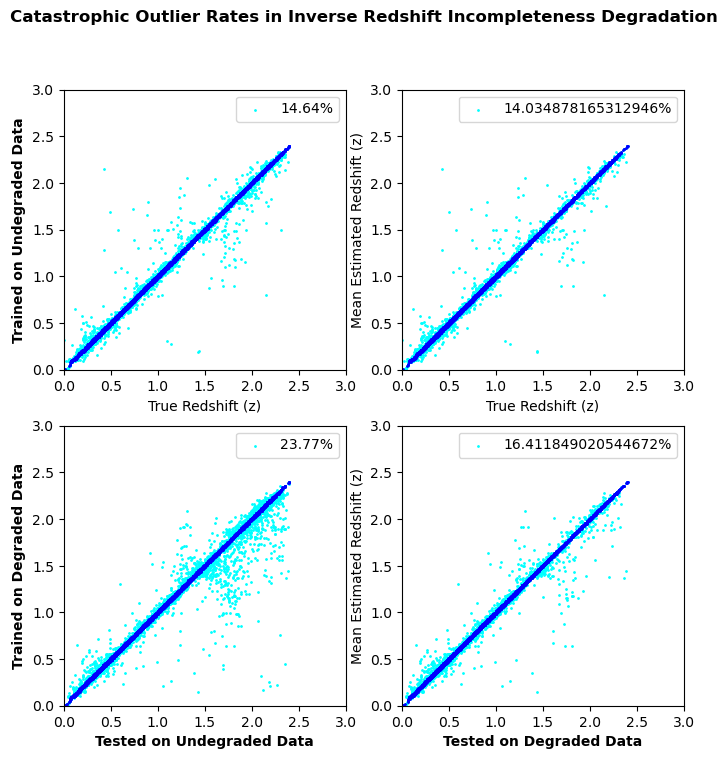

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
axes[0][0].scatter(invz_kept[0][0], invz_means[0], s = 1, color = 'cyan', label = invz_oR_outs[0])
axes[0][0].scatter(invz_kept[0][2], invz_kept[0][1], s = 1, color = 'blue')

axes[0][1].scatter(invz_kept[1][0], invz_means[1], s = 1, color = 'cyan', label = invz_oR_outs[1])
axes[0][1].scatter(invz_kept[1][2], invz_kept[1][1], s = 1, color = 'blue')

axes[1][0].scatter(invz_kept[2][0], invz_means[2], s = 1, color = 'cyan', label = invz_oR_outs[2])
axes[1][0].scatter(invz_kept[2][2], invz_kept[2][1], s = 1, color = 'blue')

axes[1][1].scatter(invz_kept[3][0], invz_means[3], s = 1, color = 'cyan', label = invz_oR_outs[3])
axes[1][1].scatter(invz_kept[3][2], invz_kept[3][1], s = 1, color = 'blue')

axes[0][0].set_ylabel("Trained on Undegraded Data", fontweight = 'bold')
axes[1][0].set_ylabel("Trained on Degraded Data", fontweight = 'bold')
axes[1][0].set_xlabel("Tested on Undegraded Data", fontweight = 'bold')
axes[1][1].set_xlabel("Tested on Degraded Data", fontweight = 'bold')

axes[0][0].set_xlim(0, 3)
axes[0][1].set_xlim(0, 3)
axes[1][0].set_xlim(0, 3)
axes[1][1].set_xlim(0, 3)

axes[0][0].set_ylim(0, 3)
axes[0][1].set_ylim(0, 3)
axes[1][0].set_ylim(0, 3)
axes[1][1].set_ylim(0, 3)

axes[0][0].set_xlabel('True Redshift (z)')
axes[0][1].set_xlabel('True Redshift (z)')

axes[0][1].set_ylabel('Mean Estimated Redshift (z)')
axes[1][1].set_ylabel('Mean Estimated Redshift (z)')

fig.suptitle('Catastrophic Outlier Rates in Inverse Redshift Incompleteness Degradation', fontsize = 'large', fontweight = 'bold')

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

## linc

In [ ]:
linc_means = [
getMeans(getXValsYVals('output_est_knearneigh_100,000_linc_o_o.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_linc_o_d.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_linc_d_o.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_linc_d_d.hdf5'))
]
linc_kept = [
runRejection(linc_orig_table, linc_means[0]), 
runRejection(linc_deg_table, linc_means[1]), 
runRejection(linc_orig_table, linc_means[2]), 
runRejection(linc_deg_table, linc_means[3])
]

In [ ]:
linc_oR_outs = oROutlierRates(linc_means, linc_kept)

o_o outlier rate is: 14.64 %
o_d outlier rate is: 18.85 %
d_o outlier rate is: 18.91 %
d_d outlier rate is: 16.57 %


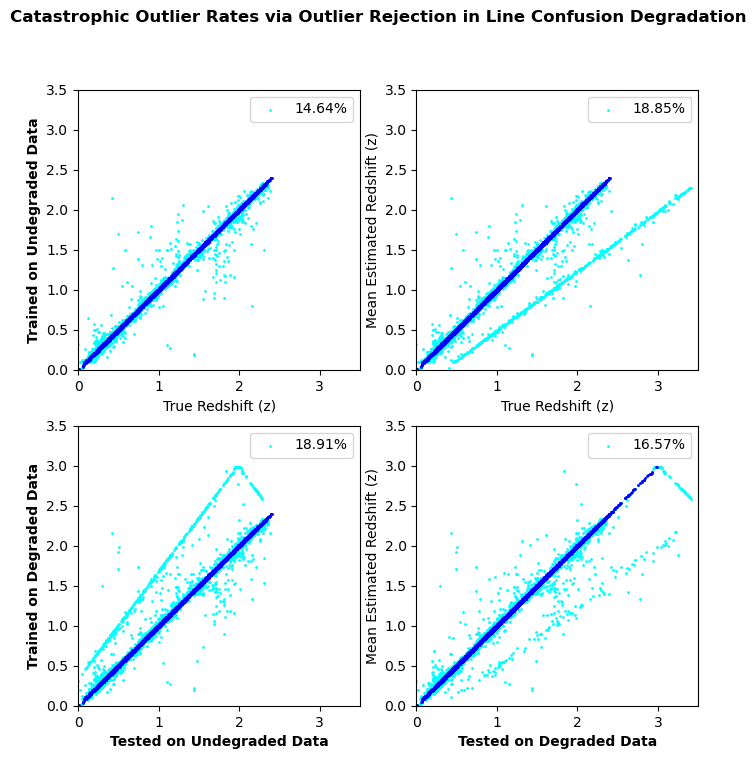

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
axes[0][0].scatter(linc_kept[0][0], linc_means[0], s = 1, color = 'cyan', label = linc_oR_outs[0])
axes[0][0].scatter(linc_kept[0][2], linc_kept[0][1], s = 1, color = 'blue')

axes[0][1].scatter(linc_kept[1][0], linc_means[1], s = 1, color = 'cyan', label = linc_oR_outs[1])
axes[0][1].scatter(linc_kept[1][2], linc_kept[1][1], s = 1, color = 'blue')

axes[1][0].scatter(linc_kept[2][0], linc_means[2], s = 1, color = 'cyan', label = linc_oR_outs[2])
axes[1][0].scatter(linc_kept[2][2], linc_kept[2][1], s = 1, color = 'blue')

axes[1][1].scatter(linc_kept[3][0], linc_means[3], s = 1, color = 'cyan', label = linc_oR_outs[3])
axes[1][1].scatter(linc_kept[3][2], linc_kept[3][1], s = 1, color = 'blue')

axes[0][0].set_ylabel("Trained on Undegraded Data", fontweight = 'bold')
axes[1][0].set_ylabel("Trained on Degraded Data", fontweight = 'bold')
axes[1][0].set_xlabel("Tested on Undegraded Data", fontweight = 'bold')
axes[1][1].set_xlabel("Tested on Degraded Data", fontweight = 'bold')

axes[0][0].set_xlim(0, 3.5)
axes[0][1].set_xlim(0, 3.5)
axes[1][0].set_xlim(0, 3.5)
axes[1][1].set_xlim(0, 3.5)

axes[0][0].set_ylim(0, 3.5)
axes[0][1].set_ylim(0, 3.5)
axes[1][0].set_ylim(0, 3.5)
axes[1][1].set_ylim(0, 3.5)

axes[0][0].set_xlabel('True Redshift (z)')
axes[0][1].set_xlabel('True Redshift (z)')

axes[0][1].set_ylabel('Mean Estimated Redshift (z)')
axes[1][1].set_ylabel('Mean Estimated Redshift (z)')

fig.suptitle('Catastrophic Outlier Rates via Outlier Rejection in Line Confusion Degradation', fontsize = 'large', fontweight = 'bold')

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

## lsst

In [ ]:
# lsst_means = [
# getMeans(getXValsYVals('output_est_knearneigh_100,000_lsst_o_o.hdf5')), 
# getMeans(getXValsYVals('output_est_knearneigh_100,000_lsst_o_d.hdf5')), 
# getMeans(getXValsYVals('output_est_knearneigh_100,000_lsst_d_o.hdf5')), 
# getMeans(getXValsYVals('output_est_knearneigh_100,000_lsst_d_d.hdf5'))
# ]
# lsst_kept = [
# runRejection(lsst_orig_table, lsst_means[0]), 
# runRejection(lsst_deg_table, lsst_means[1]), 
# runRejection(lsst_orig_table, lsst_means[2]), 
# runRejection(lsst_deg_table, lsst_means[3])
# ]

In [ ]:
# lsst_oR_outs = oROutlierRates(lsst_means, lsst_kept)

o_o outlier rate is: 14.64 %
o_d outlier rate is: 23.24 %
d_o outlier rate is: 17.98 %
d_d outlier rate is: 19.6 %


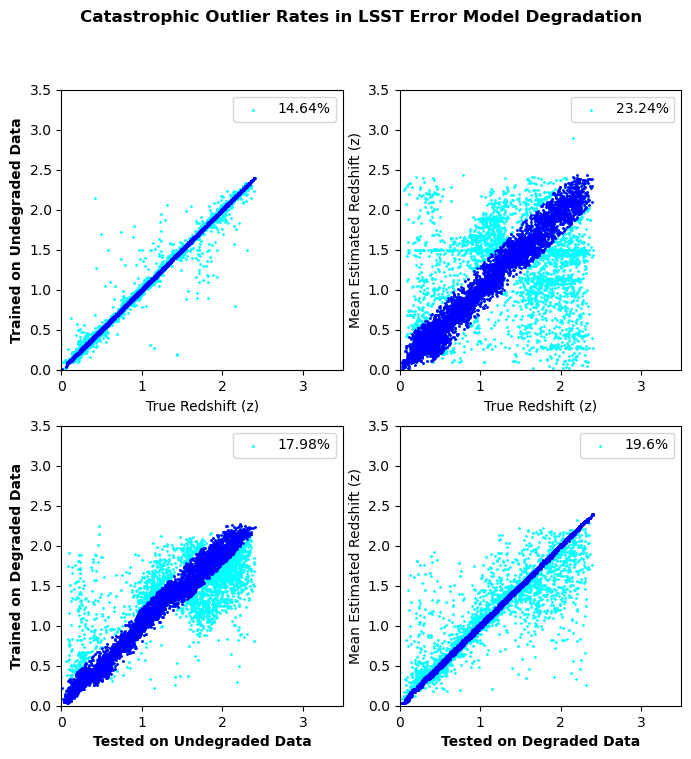

In [ ]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
# axes[0][0].scatter(lsst_kept[0][0], lsst_means[0], s = 1, color = 'cyan', label = lsst_oR_outs[0])
# axes[0][0].scatter(lsst_kept[0][2], lsst_kept[0][1], s = 1, color = 'blue')

# axes[0][1].scatter(lsst_kept[1][0], lsst_means[1], s = 1, color = 'cyan', label = lsst_oR_outs[1])
# axes[0][1].scatter(lsst_kept[1][2], lsst_kept[1][1], s = 1, color = 'blue')

# axes[1][0].scatter(lsst_kept[2][0], lsst_means[2], s = 1, color = 'cyan', label = lsst_oR_outs[2])
# axes[1][0].scatter(lsst_kept[2][2], lsst_kept[2][1], s = 1, color = 'blue')

# axes[1][1].scatter(lsst_kept[3][0], lsst_means[3], s = 1, color = 'cyan', label = lsst_oR_outs[3])
# axes[1][1].scatter(lsst_kept[3][2], lsst_kept[3][1], s = 1, color = 'blue')

# axes[0][0].set_ylabel("Trained on Undegraded Data", fontweight = 'bold')
# axes[1][0].set_ylabel("Trained on Degraded Data", fontweight = 'bold')
# axes[1][0].set_xlabel("Tested on Undegraded Data", fontweight = 'bold')
# axes[1][1].set_xlabel("Tested on Degraded Data", fontweight = 'bold')

# axes[0][0].set_xlim(0, 3.5)
# axes[0][1].set_xlim(0, 3.5)
# axes[1][0].set_xlim(0, 3.5)
# axes[1][1].set_xlim(0, 3.5)

# axes[0][0].set_ylim(0, 3.5)
# axes[0][1].set_ylim(0, 3.5)
# axes[1][0].set_ylim(0, 3.5)
# axes[1][1].set_ylim(0, 3.5)

# axes[0][0].set_xlabel('True Redshift (z)')
# axes[0][1].set_xlabel('True Redshift (z)')

# axes[0][1].set_ylabel('Mean Estimated Redshift (z)')
# axes[1][1].set_ylabel('Mean Estimated Redshift (z)')

# fig.suptitle('Catastrophic Outlier Rates in LSST Error Model Degradation', fontsize = 'large', fontweight = 'bold')

# handles1, labels1 = axes[0][0].get_legend_handles_labels()
# axes[0][0].legend(handles1, labels1)
# handles2, labels2 = axes[0][1].get_legend_handles_labels()
# axes[0][1].legend(handles2, labels2)
# handles3, labels3 = axes[1][0].get_legend_handles_labels()
# axes[1][0].legend(handles3, labels3)
# handles4, labels4 = axes[1][1].get_legend_handles_labels()
# axes[1][1].legend(handles4, labels4)

## qcut

In [ ]:
qcut_means = [
getMeans(getXValsYVals('output_est_knearneigh_100,000_qcut_o_o.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_qcut_o_d.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_qcut_d_o.hdf5')), 
getMeans(getXValsYVals('output_est_knearneigh_100,000_qcut_d_d.hdf5'))
]
qcut_kept = [
runRejection(qcut_orig_table, qcut_means[0]), 
runRejection(qcut_deg_table, qcut_means[1]), 
runRejection(qcut_orig_table, qcut_means[2]), 
runRejection(qcut_deg_table, qcut_means[3])
]

In [ ]:
qcut_oR_outs = oROutlierRates(qcut_means, qcut_kept)

o_o outlier rate is: 14.64 %
o_d outlier rate is: 14.510139960011426 %
d_o outlier rate is: 22.07 %
d_d outlier rate is: 21.565267066552412 %


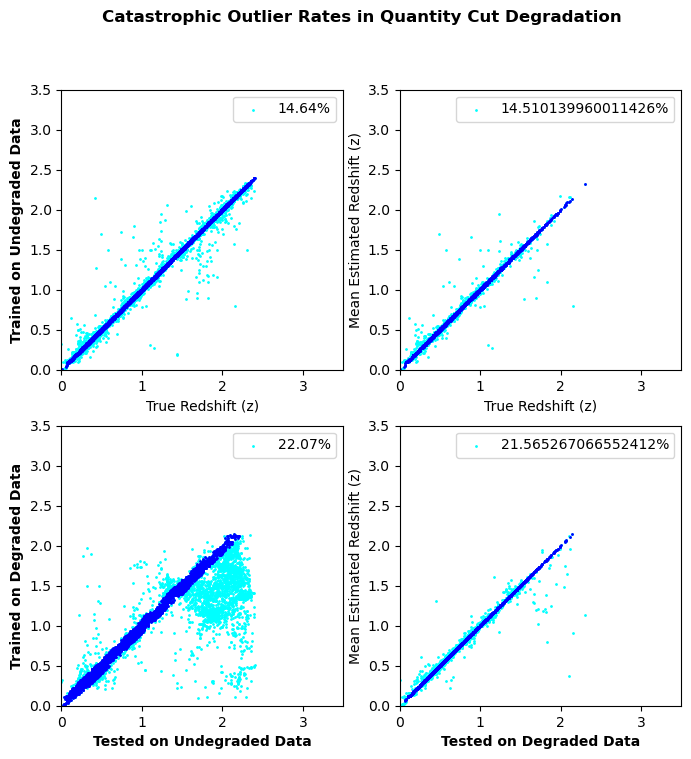

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
axes[0][0].scatter(qcut_kept[0][0], qcut_means[0], s = 1, color = 'cyan', label = qcut_oR_outs[0])
axes[0][0].scatter(qcut_kept[0][2], qcut_kept[0][1], s = 1, color = 'blue')

axes[0][1].scatter(qcut_kept[1][0], qcut_means[1], s = 1, color = 'cyan', label = qcut_oR_outs[1])
axes[0][1].scatter(qcut_kept[1][2], qcut_kept[1][1], s = 1, color = 'blue')

axes[1][0].scatter(qcut_kept[2][0], qcut_means[2], s = 1, color = 'cyan', label = qcut_oR_outs[2])
axes[1][0].scatter(qcut_kept[2][2], qcut_kept[2][1], s = 1, color = 'blue')

axes[1][1].scatter(qcut_kept[3][0], qcut_means[3], s = 1, color = 'cyan', label = qcut_oR_outs[3])
axes[1][1].scatter(qcut_kept[3][2], qcut_kept[3][1], s = 1, color = 'blue')

axes[0][0].set_ylabel("Trained on Undegraded Data", fontweight = 'bold')
axes[1][0].set_ylabel("Trained on Degraded Data", fontweight = 'bold')
axes[1][0].set_xlabel("Tested on Undegraded Data", fontweight = 'bold')
axes[1][1].set_xlabel("Tested on Degraded Data", fontweight = 'bold')

axes[0][0].set_xlim(0, 3.5)
axes[0][1].set_xlim(0, 3.5)
axes[1][0].set_xlim(0, 3.5)
axes[1][1].set_xlim(0, 3.5)

axes[0][0].set_ylim(0, 3.5)
axes[0][1].set_ylim(0, 3.5)
axes[1][0].set_ylim(0, 3.5)
axes[1][1].set_ylim(0, 3.5)

axes[0][0].set_xlabel('True Redshift (z)')
axes[0][1].set_xlabel('True Redshift (z)')

axes[0][1].set_ylabel('Mean Estimated Redshift (z)')
axes[1][1].set_ylabel('Mean Estimated Redshift (z)')

fig.suptitle('Catastrophic Outlier Rates in Quantity Cut Degradation', fontsize = 'large', fontweight = 'bold')

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

# Mean vs Mode 

In [ ]:
import numpy as np
from scipy import stats 

def getStdevs(tuple):
    stdevs = []
    for i in range(len(tuple[1])):
        mean = np.sum(tuple[0] * tuple[1][i]) / np.sum(tuple[1][i])
        var = np.sum((mean - tuple[0])**2 * tuple[1][i]) / np.sum(tuple[1][i])
        stdev = np.sqrt(var)
        stdevs.append(stdev)
    max = np.max(stdevs)
    return [np.asarray(stdevs), max]

def getModes(filename):
    file = h5py.File(filename, 'r')
    ancil = file['ancil'] 
    zmodes = ancil['zmode']
    return np.asarray(zmodes)

def getMMOutliers(means, modes, stdevs):
    dists = []
    for i in range(len(means)):
        dist = np.abs(means[i] - modes[i]) / np.sqrt(2)
        dists.append(dist)
    stdev = stats.tstd(dists)
    ct = 0
    for i in dists:
        if i >= 3*stdev:
            ct += 1
    return str((ct / len(means))*100) + '%'

## invz

In [ ]:
## get modes & stdevs 

invz_zmodes = [
    getModes('output_est_knearneigh_100,000_invz_o_o.hdf5'), 
    getModes('output_est_knearneigh_100,000_invz_o_d.hdf5'), 
    getModes('output_est_knearneigh_100,000_invz_d_o.hdf5'), 
    getModes('output_est_knearneigh_100,000_invz_d_d.hdf5')
]

invz_stdevs = [
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_o_o.hdf5'))[0], 
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_o_d.hdf5'))[0],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_d_o.hdf5'))[0],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_d_d.hdf5'))[0]
]

invz_max_stdev = np.max(np.asarray([
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_o_o.hdf5'))[1], 
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_o_d.hdf5'))[1],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_d_o.hdf5'))[1],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_invz_d_d.hdf5'))[1] ])
)

In [ ]:
invz_MM_outs = [
getMMOutliers(invz_means[0], invz_zmodes[0], invz_stdevs[0]), 
getMMOutliers(invz_means[1], invz_zmodes[1], invz_stdevs[1]), 
getMMOutliers(invz_means[2], invz_zmodes[2], invz_stdevs[2]), 
getMMOutliers(invz_means[3], invz_zmodes[3], invz_stdevs[3])]

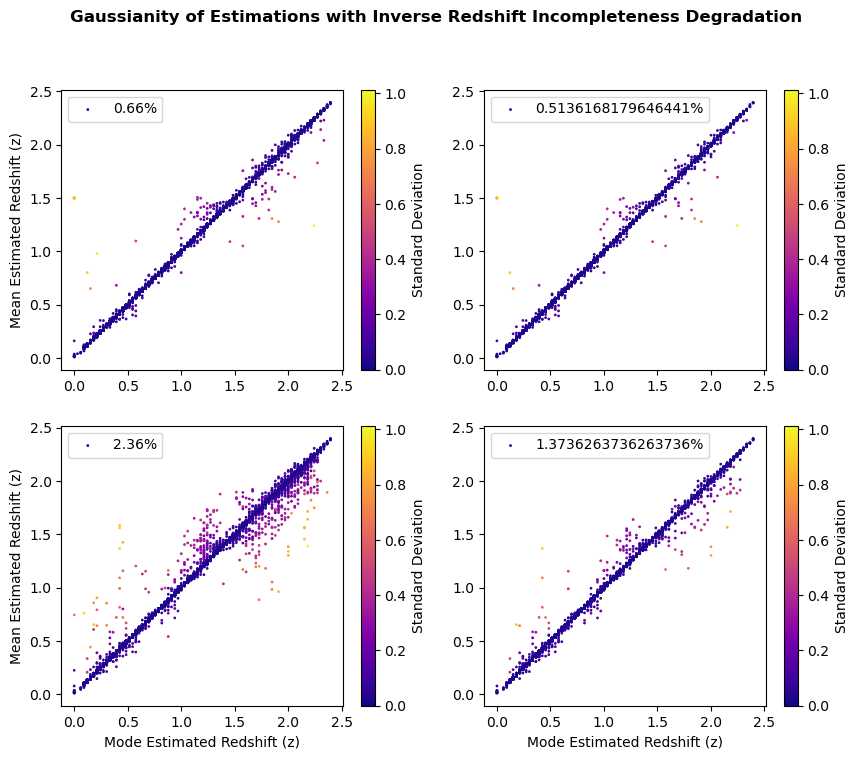

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm 

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
data_0 = axes[0][0].scatter(invz_zmodes[0], invz_means[0], s = 1, c = invz_stdevs[0], cmap = cm.plasma, vmin = 0, vmax = invz_max_stdev, label = invz_MM_outs[0])
fig.colorbar(data_0, ax=axes[0][0], label = 'Standard Deviation')
data_1 = axes[0][1].scatter(invz_zmodes[1], invz_means[1], s = 1, c = invz_stdevs[1], cmap = cm.plasma, vmin = 0, vmax = invz_max_stdev, label = invz_MM_outs[1])
fig.colorbar(data_1, ax=axes[0][1], label = 'Standard Deviation')
data_2 = axes[1][0].scatter(invz_zmodes[2], invz_means[2], s = 1, c = invz_stdevs[2], cmap = cm.plasma, vmin = 0, vmax = invz_max_stdev, label = invz_MM_outs[2])
fig.colorbar(data_2, ax=axes[1][0], label = 'Standard Deviation')
data_3 = axes[1][1].scatter(invz_zmodes[3], invz_means[3], s = 1, c = invz_stdevs[3], cmap = cm.plasma, vmin = 0, vmax = invz_max_stdev, label = invz_MM_outs[3])
fig.colorbar(data_3, ax=axes[1][1], label = 'Standard Deviation')


axes[1][0].set_xlabel('Mode Estimated Redshift (z)')
axes[1][1].set_xlabel('Mode Estimated Redshift (z)')
axes[0][0].set_ylabel('Mean Estimated Redshift (z)')
axes[1][0].set_ylabel('Mean Estimated Redshift (z)')

fig.suptitle('Gaussianity of Estimations with Inverse Redshift Incompleteness Degradation', fontsize = 'large', fontweight = 'bold')

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)


## linc

In [ ]:
linc_zmodes = [
    getModes('output_est_knearneigh_100,000_linc_o_o.hdf5'), 
    getModes('output_est_knearneigh_100,000_linc_o_d.hdf5'), 
    getModes('output_est_knearneigh_100,000_linc_d_o.hdf5'), 
    getModes('output_est_knearneigh_100,000_linc_d_d.hdf5')
]

linc_stdevs = [
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_o_o.hdf5'))[0], 
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_o_d.hdf5'))[0],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_d_o.hdf5'))[0],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_d_d.hdf5'))[0]
]

linc_max_stdev = np.max(np.asarray([
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_o_o.hdf5'))[1], 
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_o_d.hdf5'))[1],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_d_o.hdf5'))[1],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_linc_d_d.hdf5'))[1] ])
)

In [ ]:
linc_MM_outs = [
getMMOutliers(linc_means[0], linc_zmodes[0], linc_stdevs[0]), 
getMMOutliers(linc_means[1], linc_zmodes[1], linc_stdevs[1]), 
getMMOutliers(linc_means[2], linc_zmodes[2], linc_stdevs[2]), 
getMMOutliers(linc_means[3], linc_zmodes[3], linc_stdevs[3])]

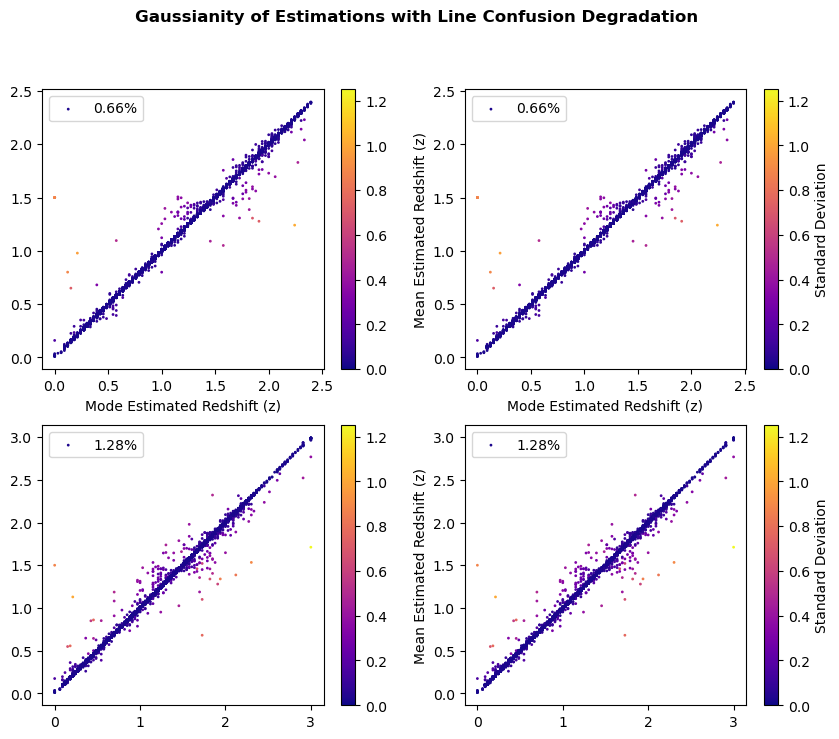

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
data_0 = axes[0][0].scatter(linc_zmodes[0], linc_means[0], s = 1, c = linc_stdevs[0], cmap = cm.plasma, vmin = 0, vmax = linc_max_stdev, label = linc_MM_outs[0] )
fig.colorbar(data_0, ax=axes[0][0])# label = 'Standard Deviation')
data_1 = axes[0][1].scatter(linc_zmodes[1], linc_means[1], s = 1, c = linc_stdevs[1], cmap = cm.plasma, vmin = 0, vmax = linc_max_stdev, label = linc_MM_outs[1])
fig.colorbar(data_1, ax=axes[0][1], label = 'Standard Deviation')
data_2 = axes[1][0].scatter(linc_zmodes[2], linc_means[2], s = 1, c = linc_stdevs[2], cmap = cm.plasma, vmin = 0, vmax = linc_max_stdev, label = linc_MM_outs[2] )
fig.colorbar(data_2, ax=axes[1][0])# label = 'Standard Deviation')
data_3 = axes[1][1].scatter(linc_zmodes[3], linc_means[3], s = 1, c = linc_stdevs[3], cmap = cm.plasma, vmin = 0, vmax = linc_max_stdev, label = linc_MM_outs[3] )
fig.colorbar(data_3, ax=axes[1][1], label = 'Standard Deviation')


axes[0][0].set_xlabel('Mode Estimated Redshift (z)')
axes[0][1].set_xlabel('Mode Estimated Redshift (z)')
axes[0][1].set_ylabel('Mean Estimated Redshift (z)')
axes[1][1].set_ylabel('Mean Estimated Redshift (z)')

fig.suptitle('Gaussianity of Estimations with Line Confusion Degradation', fontsize = 'large', fontweight = 'bold')

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

## lsst

In [ ]:
# lsst_zmodes = [
#     getModes('output_est_knearneigh_100,000_lsst_o_o.hdf5'), 
#     getModes('output_est_knearneigh_100,000_lsst_o_d.hdf5'), 
#     getModes('output_est_knearneigh_100,000_lsst_d_o.hdf5'), 
#     getModes('output_est_knearneigh_100,000_lsst_d_d.hdf5')
# ]

# lsst_stdevs = [
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_o_o.hdf5'))[0], 
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_o_d.hdf5'))[0],
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_d_o.hdf5'))[0],
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_d_d.hdf5'))[0]
# ]

# lsst_max_stdev = np.max(np.asarray([
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_o_o.hdf5'))[1], 
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_o_d.hdf5'))[1],
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_d_o.hdf5'))[1],
#     getStdevs(getXValsYVals('output_est_knearneigh_100,000_lsst_d_d.hdf5'))[1] ])
# )

In [ ]:
# lsst_MM_outs = [
#     getMMOutliers(lsst_means[0], lsst_zmodes[0], lsst_stdevs[0]),
#     getMMOutliers(lsst_means[1], lsst_zmodes[1], lsst_stdevs[1]),
#     getMMOutliers(lsst_means[2], lsst_zmodes[2], lsst_stdevs[2]),
#     getMMOutliers(lsst_means[3], lsst_zmodes[3], lsst_stdevs[3])
#     ]

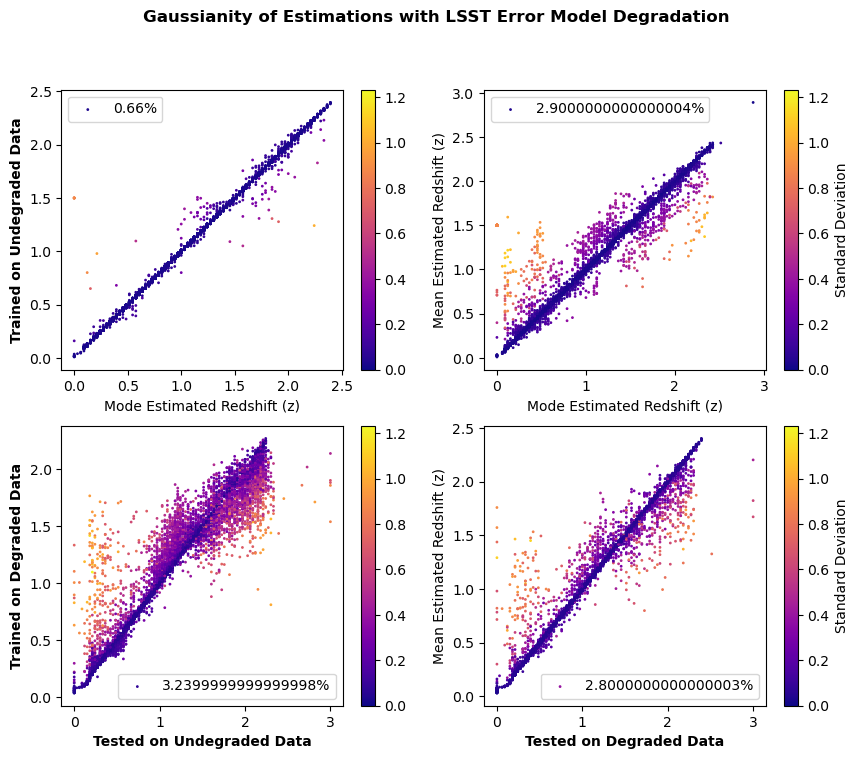

In [ ]:
# fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
# data_0 = axes[0][0].scatter(lsst_zmodes[0], lsst_means[0], s = 1, c = lsst_stdevs[0], cmap = cm.plasma, vmin = 0, vmax = lsst_max_stdev, label = lsst_MM_outs[0] )
# fig.colorbar(data_0, ax=axes[0][0])# label = 'Standard Deviation')
# data_1 = axes[0][1].scatter(lsst_zmodes[1], lsst_means[1], s = 1, c = lsst_stdevs[1], cmap = cm.plasma, vmin = 0, vmax = lsst_max_stdev, label = lsst_MM_outs[1])
# fig.colorbar(data_1, ax=axes[0][1], label = 'Standard Deviation')
# data_2 = axes[1][0].scatter(lsst_zmodes[2], lsst_means[2], s = 1, c = lsst_stdevs[2], cmap = cm.plasma, vmin = 0, vmax = lsst_max_stdev, label = lsst_MM_outs[2] )
# fig.colorbar(data_2, ax=axes[1][0])# label = 'Standard Deviation')
# data_3 = axes[1][1].scatter(lsst_zmodes[3], lsst_means[3], s = 1, c = lsst_stdevs[3], cmap = cm.plasma, vmin = 0, vmax = lsst_max_stdev, label = lsst_MM_outs[3] )
# fig.colorbar(data_3, ax=axes[1][1], label = 'Standard Deviation')


# axes[0][0].set_xlabel('Mode Estimated Redshift (z)')
# axes[0][1].set_xlabel('Mode Estimated Redshift (z)')
# axes[0][1].set_ylabel('Mean Estimated Redshift (z)')
# axes[1][1].set_ylabel('Mean Estimated Redshift (z)')

# axes[0][0].set_ylabel("Trained on Undegraded Data", fontweight = 'bold')
# axes[1][0].set_ylabel("Trained on Degraded Data", fontweight = 'bold')
# axes[1][0].set_xlabel("Tested on Undegraded Data", fontweight = 'bold')
# axes[1][1].set_xlabel("Tested on Degraded Data", fontweight = 'bold')


# fig.suptitle('Gaussianity of Estimations with LSST Error Model Degradation', fontsize = 'large', fontweight = 'bold')

# handles1, labels1 = axes[0][0].get_legend_handles_labels()
# axes[0][0].legend(handles1, labels1)
# handles2, labels2 = axes[0][1].get_legend_handles_labels()
# axes[0][1].legend(handles2, labels2)
# handles3, labels3 = axes[1][0].get_legend_handles_labels()
# axes[1][0].legend(handles3, labels3)
# handles4, labels4 = axes[1][1].get_legend_handles_labels()
# axes[1][1].legend(handles4, labels4)

## qcut

In [ ]:
qcut_zmodes = [
    getModes('output_est_knearneigh_100,000_qcut_o_o.hdf5'), 
    getModes('output_est_knearneigh_100,000_qcut_o_d.hdf5'), 
    getModes('output_est_knearneigh_100,000_qcut_d_o.hdf5'), 
    getModes('output_est_knearneigh_100,000_qcut_d_d.hdf5')
]

qcut_stdevs = [
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_o_o.hdf5'))[0], 
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_o_d.hdf5'))[0],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_d_o.hdf5'))[0],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_d_d.hdf5'))[0]
]

qcut_max_stdev = np.max(np.asarray([
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_o_o.hdf5'))[1], 
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_o_d.hdf5'))[1],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_d_o.hdf5'))[1],
    getStdevs(getXValsYVals('output_est_knearneigh_100,000_qcut_d_d.hdf5'))[1] ])
)

In [ ]:
qcut_MM_outs = [
getMMOutliers(qcut_means[0], qcut_zmodes[0], qcut_stdevs[0]),
getMMOutliers(qcut_means[1], qcut_zmodes[1], qcut_stdevs[1]),
getMMOutliers(qcut_means[2], qcut_zmodes[2], qcut_stdevs[2]),
getMMOutliers(qcut_means[3], qcut_zmodes[3], qcut_stdevs[3])]

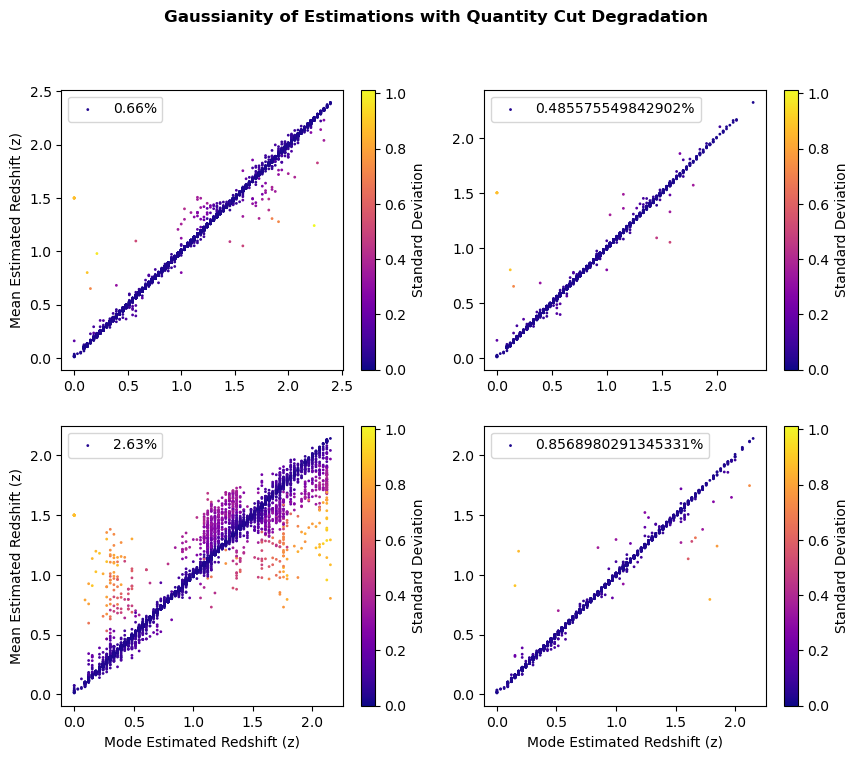

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 8))
data_0 = axes[0][0].scatter(qcut_zmodes[0], qcut_means[0], s = 1, c = qcut_stdevs[0], cmap = cm.plasma, vmin = 0, vmax = qcut_max_stdev, label = qcut_MM_outs[0] )
fig.colorbar(data_0, ax=axes[0][0], label = 'Standard Deviation')
data_1 = axes[0][1].scatter(qcut_zmodes[1], qcut_means[1], s = 1, c = qcut_stdevs[1], cmap = cm.plasma, vmin = 0, vmax = qcut_max_stdev, label = qcut_MM_outs[1] )
fig.colorbar(data_1, ax=axes[0][1], label = 'Standard Deviation')
data_2 = axes[1][0].scatter(qcut_zmodes[2], qcut_means[2], s = 1, c = qcut_stdevs[2], cmap = cm.plasma, vmin = 0, vmax = qcut_max_stdev, label = qcut_MM_outs[2] )
fig.colorbar(data_2, ax=axes[1][0], label = 'Standard Deviation')
data_3 = axes[1][1].scatter(qcut_zmodes[3], qcut_means[3], s = 1, c = qcut_stdevs[3], cmap = cm.plasma, vmin = 0, vmax = qcut_max_stdev, label = qcut_MM_outs[3] )
fig.colorbar(data_3, ax=axes[1][1], label = 'Standard Deviation')


axes[1][0].set_xlabel('Mode Estimated Redshift (z)')
axes[1][1].set_xlabel('Mode Estimated Redshift (z)')
axes[0][0].set_ylabel('Mean Estimated Redshift (z)')
axes[1][0].set_ylabel('Mean Estimated Redshift (z)')

fig.suptitle('Gaussianity of Estimations with Quantity Cut Degradation', fontsize = 'large',fontweight = 'bold')

handles1, labels1 = axes[0][0].get_legend_handles_labels()
axes[0][0].legend(handles1, labels1)
handles2, labels2 = axes[0][1].get_legend_handles_labels()
axes[0][1].legend(handles2, labels2)
handles3, labels3 = axes[1][0].get_legend_handles_labels()
axes[1][0].legend(handles3, labels3)
handles4, labels4 = axes[1][1].get_legend_handles_labels()
axes[1][1].legend(handles4, labels4)

# Outlier Rates Table

In [ ]:
# import matplotlib.pyplot as plt
# import pandas as pd 

# fig, ax = plt.subplots(1, 1)

# col_labels = ['Deg. Combination', 'Outlier Rejection', 'PIT', 'Gaussianity']
# row_labels = ['Orig, Orig', 'Orig, Deg', 'Deg, Orig', 'Deg, Deg']
# data = [
#     ['Orig, Orig', 5.7, 2.5, 1.1], ['Orig, Deg', 5.5, 2.6, 1.0], ['Deg, Orig', 7.1, 3.2, 1.5], ['Deg, Deg', 5.7, 2.4, 1.2],
#     ['Orig, Orig', 5.7, 2.5, 1.1], ['Orig, Deg', 10.4, 3.0, 1.1], ['Deg, Orig', 6.5, 7.3, 1.0], ['Deg, Deg', 10.2, 6.8, 1.0], 
#     ['Orig, Orig', 5.7, 2.5, 1.1], ['Orig, Deg', 24.0, 46.6, 2.2], ['Deg, Orig', 14.8, 1.6, 3.3], ['Deg, Deg', 13.9, 1.8, 3.6], 
#     ['Orig, Orig', 5.7, 2.5, 1.1], ['Orig, Deg', 5.4, 2.9, 0.9], ['Deg, Orig', 17.9, 11.8, 3.4], ['Deg, Deg', 6.1, 1.5, 1.2]
#     ]

# df = pd.DataFrame(data, columns = col_labels)

# ax.axis('tight')
# ax.axis('off')

# table = ax.table(cellText = df.values, 
#                  colLabels = df.columns, rowColours = ['red', 'red', 'red','red','yellow', 'yellow','yellow','yellow','green','green','green','green','blue', 'blue', 'blue' ,'blue'], rowLabels = ['Inverse z Inc.', '$z_o$= 1.0', '$p_{rej}$=0, z<1', '$p_{rej}$=1-1/z, z>1', 'Line Confusion','$\lambda_{true}$=5507nm', '$\lambda_{false}$=3727nm', 'rate=0.05','LSST Error','default params.', ' ', ' ','Quantity Cuts','band = i', 'mag = 25.0', ' ' ], loc = 'center')#, rowLables = row_labels, loc = 'center')
# table.set_fontsize(15)
# table.scale(2, 2)
# plt.show()